# Fashion MNIST Image Classification on TPU

author: **Khuong Vo**

Building a convolutional neural network that learns to predict one of the 10 classes of the Fashion-MNIST dataset which comprises grayscale images of 10 different classes of clothes. https://www.tensorflow.org/tutorials/keras/basic_classification

This notebook is based on the **fast.ai** course v1

Run on **TPUs** in **Google Colab**

**Fashion MNIST image classification with different approaches:**
  1. **Linear model**
  2. **Single dense layer**
  3. **Basic 'VGG-style' CNN**
  4. **Data augmentation**
  5. **Batchnorm + data augmentation**
  6. **Batchnorm + dropout + data augmentation**
  7. **Octave Convolution + (6)** (No registered 'ResizeNearestNeighborGrad' error, https://github.com/tensorflow/tensorflow/issues/26214, while DistributionStrategy currently does not support generator)
  9. **Ensembling**
    
**Each approach is run with different learning rates (.1, .01, .001, .0001)**

## Setup

Import necessary libraries

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!mkdir -p '/content/drive/My Drive/colab_models/fashion_mnist/'

In [0]:
!pip install tensorflow==1.11.0

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Activation, Dropout, Flatten, Dense

tf.logging.set_verbosity(tf.logging.WARN)

In [0]:
import os
import pprint

if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
    # This address identifies the TPU we'll use when configuring TensorFlow.
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print ('TPU address is', TPU_WORKER)

with tf.Session(TPU_WORKER) as session:
    devices = session.list_devices()

print('TPU devices:')
pprint.pprint(devices)

TPU address is grpc://10.82.70.226:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 888844707818826604),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14203919949827900503),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17429329624840439278),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7758059339624291602),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 15149420431265885307),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 6013759829510821234),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 3284503332643012985),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12791522434716519699),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 6396862005964

## Data preprocessing

Each image is mapped to a single label corresponding to index ranging from 0 to 9

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

The Fashion MNIST dataset which contains 70,000 grayscale images in 10 categories. Each image has a size of 28 x 28 pixel. 60,000 images are used to train the network and 10,000 images are used to evaluate how accurately the network learned to classify images.

In [0]:
(X, y), (X_test, y_test) = fashion_mnist.load_data()
(X.shape, y.shape, X_test.shape, y_test.shape)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

I would split the 60k images into 50k for training and 10k for validation.

In [0]:
X_train = X[:50000]
y_train = y[:50000]
X_valid = X[50000:]
y_valid = y[50000:]

Inspect the first image in the training set, we can see that the pixel values fall in the range of 0 to 255:

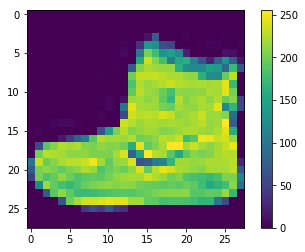

In [0]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)

Display the first 25 images from the training set and display the class name below each image.

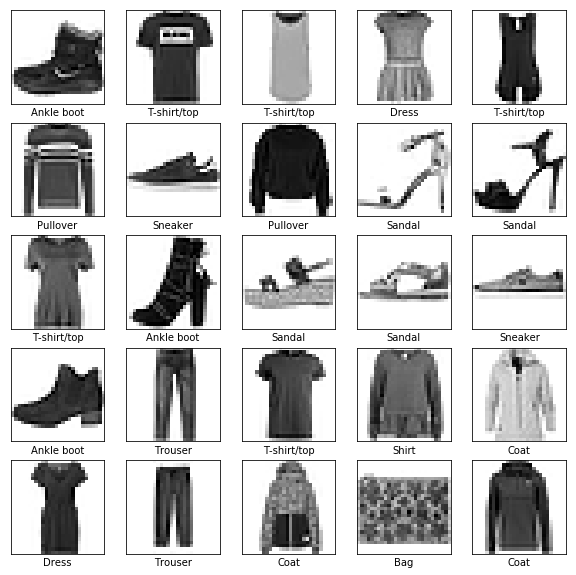

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

Adding a color channel dimension. Since all the images are in grayscale, the number of channels is 1

In [0]:
X_test = np.expand_dims(X_test, -1)
X_valid = np.expand_dims(X_valid, -1)
X_train = np.expand_dims(X_train, -1)

In [0]:
X_train.shape

(50000, 28, 28, 1)

In [0]:
y_train[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

Choose a batch size that fits TPU memory

In [0]:
batch_size = 1024

Images are normalized by subtracting the mean and dividing by standard deviation

In [0]:
gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
gen.fit(X_train)
batches = gen.flow(X_train, y_train, batch_size=batch_size)
valid_batches = gen.flow(X_valid, y_valid, batch_size=batch_size)
test_batches = gen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

In [0]:
model_path = '/content/drive/My Drive/colab_models/fashion_mnist/'
def save_model(model, name, del_model=True):
    model.save_weights(model_path + name, overwrite=True)
    if del_model:
        del model

## Linear model

**1. First, I would try with the simple linear model with the following architecture:**  
Weights are initialized by Xavier Glorot initialization scheme.

In [0]:
def get_lin_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)), 
        Dense(10, activation='softmax')])
    
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER))
    )
    
    tpu_model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return tpu_model

In [0]:
lm = get_lin_model()

In [0]:
lm.fit_generator(batches, epochs=1, validation_data=valid_batches)

Epoch 1/1
49/49 [==============================] - 7s 133ms/step - loss: 1.1123 - sparse_categorical_accuracy: 0.6119 - val_loss: 0.6389 - val_sparse_categorical_accuracy: 0.7664


In [0]:
lm.optimizer.lr = 0.1

In [0]:
lm.fit_generator(batches, epochs=1, validation_data=valid_batches)

Epoch 1/1
49/49 [==============================] - 3s 54ms/step - loss: 0.6037 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.5613 - val_sparse_categorical_accuracy: 0.7928


In [0]:
lm.optimizer.lr = 0.01

In [0]:
lm.fit_generator(batches, epochs=4, validation_data=valid_batches)

Epoch 1/4
49/49 [==============================] - 3s 51ms/step - loss: 0.5511 - sparse_categorical_accuracy: 0.8109 - val_loss: 0.5235 - val_sparse_categorical_accuracy: 0.8096
Epoch 2/4
49/49 [==============================] - 2s 50ms/step - loss: 0.4964 - sparse_categorical_accuracy: 0.8291 - val_loss: 0.5004 - val_sparse_categorical_accuracy: 0.8176
Epoch 3/4
49/49 [==============================] - 3s 54ms/step - loss: 0.4834 - sparse_categorical_accuracy: 0.8354 - val_loss: 0.4717 - val_sparse_categorical_accuracy: 0.8256
Epoch 4/4
49/49 [==============================] - 3s 56ms/step - loss: 0.4824 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.4618 - val_sparse_categorical_accuracy: 0.8288


In [0]:
test_loss, test_acc = lm.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

Test accuracy: 0.8199999975204468


In [0]:
save_model(lm, 'linear_model.h5')
clear_session()

## Single dense layer

**2. Second, I would add a non-linear layer with a relu activation:**

In [0]:
def get_fc_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')
        ])
    
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER))
    )
    
    tpu_model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return tpu_model

In [0]:
fc = get_fc_model()

In [0]:
fc.fit_generator(batches, epochs=1, validation_data=valid_batches)

Epoch 1/1
49/49 [==============================] - 10s 204ms/step - loss: 0.7134 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.5611 - val_sparse_categorical_accuracy: 0.7936


In [0]:
fc.optimizer.lr = 0.1

In [0]:
fc.fit_generator(batches, epochs=4, validation_data=valid_batches)

Epoch 1/4
49/49 [==============================] - 3s 58ms/step - loss: 0.4482 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.3987 - val_sparse_categorical_accuracy: 0.8648
Epoch 2/4
49/49 [==============================] - 2s 51ms/step - loss: 0.3998 - sparse_categorical_accuracy: 0.8583 - val_loss: 0.3782 - val_sparse_categorical_accuracy: 0.8624
Epoch 3/4
49/49 [==============================] - 3s 56ms/step - loss: 0.3446 - sparse_categorical_accuracy: 0.8773 - val_loss: 0.3642 - val_sparse_categorical_accuracy: 0.8712
Epoch 4/4
49/49 [==============================] - 3s 51ms/step - loss: 0.3393 - sparse_categorical_accuracy: 0.8814 - val_loss: 0.3629 - val_sparse_categorical_accuracy: 0.8728


In [0]:
fc.optimizer.lr = 0.01

In [0]:
fc.fit_generator(batches, epochs=4, validation_data=valid_batches)

Epoch 1/4
49/49 [==============================] - 3s 60ms/step - loss: 0.3299 - sparse_categorical_accuracy: 0.8862 - val_loss: 0.3401 - val_sparse_categorical_accuracy: 0.8840
Epoch 2/4
49/49 [==============================] - 3s 55ms/step - loss: 0.3145 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.3439 - val_sparse_categorical_accuracy: 0.8776
Epoch 3/4
49/49 [==============================] - 3s 55ms/step - loss: 0.2895 - sparse_categorical_accuracy: 0.8959 - val_loss: 0.3184 - val_sparse_categorical_accuracy: 0.8888
Epoch 4/4
49/49 [==============================] - 3s 58ms/step - loss: 0.2832 - sparse_categorical_accuracy: 0.8950 - val_loss: 0.3085 - val_sparse_categorical_accuracy: 0.8856


In [0]:
test_loss, test_acc = fc.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

Test accuracy: 0.8735999982833862


In [0]:
save_model(fc, 'fc_model.h5')
clear_session()

## Basic 'VGG-style' CNN

**3. Third, I would try the architecture similar to VGG16:**  
The VGG model won the 2014 Imagenet competition and is a very simple model to create and understand.

In [0]:
def get_model():
    model = Sequential([
        Conv2D(32,(3, 3), activation='relu', input_shape=(28, 28, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPool2D(),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')
        ])
    
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER))
    )
    
    tpu_model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return tpu_model

In [0]:
model = get_model()

In [0]:
model.fit_generator(batches, epochs=1, validation_data=valid_batches)

Epoch 1/1
49/49 [==============================] - 21s 428ms/step - loss: 0.9071 - sparse_categorical_accuracy: 0.6804 - val_loss: 0.5072 - val_sparse_categorical_accuracy: 0.7936


In [0]:
model.optimizer.lr = 0.1

In [0]:
model.fit_generator(batches, epochs=1, validation_data=valid_batches)

Epoch 1/1
49/49 [==============================] - 3s 65ms/step - loss: 0.5326 - sparse_categorical_accuracy: 0.8102 - val_loss: 0.5241 - val_sparse_categorical_accuracy: 0.8184


In [0]:
model.optimizer.lr = 0.01

In [0]:
model.fit_generator(batches, epochs=8, validation_data=valid_batches)

Epoch 1/8
49/49 [==============================] - 3s 62ms/step - loss: 0.4397 - sparse_categorical_accuracy: 0.8433 - val_loss: 0.4295 - val_sparse_categorical_accuracy: 0.8544
Epoch 2/8
49/49 [==============================] - 3s 66ms/step - loss: 0.3711 - sparse_categorical_accuracy: 0.8641 - val_loss: 0.5383 - val_sparse_categorical_accuracy: 0.8088
Epoch 3/8
49/49 [==============================] - 3s 64ms/step - loss: 0.3773 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.3794 - val_sparse_categorical_accuracy: 0.8648
Epoch 4/8
49/49 [==============================] - 3s 67ms/step - loss: 0.3162 - sparse_categorical_accuracy: 0.8862 - val_loss: 0.3395 - val_sparse_categorical_accuracy: 0.8872
Epoch 5/8
49/49 [==============================] - 3s 62ms/step - loss: 0.3014 - sparse_categorical_accuracy: 0.8911 - val_loss: 0.3064 - val_sparse_categorical_accuracy: 0.8968
Epoch 6/8
49/49 [==============================] - 3s 65ms/step - loss: 0.2735 - sparse_categorical_accuracy: 

In [0]:
test_loss, test_acc = model.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

Test accuracy: 0.892800000667572


In [0]:
save_model(model, 'vgg_model.h5')
clear_session()

## Handling overfitting

Here, the training accuracy so far has been higher than the validation accuracy, which also means overfitting. We have to propose approaches to reducing **overfitting**. We do not necessarily need to rely on dropout or other regularization approaches to reduce overfitting. There are other techniques we should try first, since regularization, by definition, biases our model towards simplicity - which we only want to do if we know that's necessary. This is the order that I use for reducing overfitting:
  1. Add more data
  2. Use data augmentation
  3. Use architectures that generalize well
  4. Add regularization
  5. Reduce architecture complexity.

## Data augmentation

**4. Fourth, adding data augmentation:**  
With the assumption that we've already collected as much data as we can, so step (1) isn't relevant. So the next step (2) is data augmentation. This refers to creating additional synthetic data, based on reasonable modifications of our input data. For images, this is likely to involve one or more of: flipping, rotation, zooming, cropping, panning, minor color changes.
For our photos, we'll want to use horizontal flipping, but not vertical flipping (since an upside down shirt is much less common than a shirt the right way up, for instance!)

In [0]:
gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, 
                         rotation_range=8, width_shift_range=0.08, shear_range=0.3, 
                         height_shift_range=0.08, zoom_range=0.08)
gen.fit(X_train)
batches = gen.flow(X_train, y_train, batch_size=batch_size)

In [0]:
model = get_model()

In [0]:
model.fit_generator(batches, epochs=1, validation_data=valid_batches)

Epoch 1/1
49/49 [==============================] - 33s 681ms/step - loss: 1.0944 - sparse_categorical_accuracy: 0.6074 - val_loss: 0.7076 - val_sparse_categorical_accuracy: 0.7136


In [0]:
model.optimizer.lr = 0.1

In [0]:
model.fit_generator(batches, epochs=4, validation_data=valid_batches)

Epoch 1/4
49/49 [==============================] - 13s 261ms/step - loss: 0.6504 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.5299 - val_sparse_categorical_accuracy: 0.7880
Epoch 2/4
49/49 [==============================] - 12s 244ms/step - loss: 0.5650 - sparse_categorical_accuracy: 0.7860 - val_loss: 0.4696 - val_sparse_categorical_accuracy: 0.8096
Epoch 3/4
49/49 [==============================] - 13s 256ms/step - loss: 0.4813 - sparse_categorical_accuracy: 0.8204 - val_loss: 0.4162 - val_sparse_categorical_accuracy: 0.8432
Epoch 4/4
49/49 [==============================] - 12s 250ms/step - loss: 0.4581 - sparse_categorical_accuracy: 0.8252 - val_loss: 0.4078 - val_sparse_categorical_accuracy: 0.8480


In [0]:
model.optimizer.lr = 0.01

In [0]:
model.fit_generator(batches, epochs=8, validation_data=valid_batches)

Epoch 1/8
49/49 [==============================] - 13s 258ms/step - loss: 0.4124 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.3684 - val_sparse_categorical_accuracy: 0.8648
Epoch 2/8
49/49 [==============================] - 12s 252ms/step - loss: 0.4033 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.3275 - val_sparse_categorical_accuracy: 0.8760
Epoch 3/8
49/49 [==============================] - 12s 254ms/step - loss: 0.3717 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.3451 - val_sparse_categorical_accuracy: 0.8728
Epoch 4/8
49/49 [==============================] - 12s 251ms/step - loss: 0.3627 - sparse_categorical_accuracy: 0.8641 - val_loss: 0.3461 - val_sparse_categorical_accuracy: 0.8712
Epoch 5/8
49/49 [==============================] - 13s 257ms/step - loss: 0.3422 - sparse_categorical_accuracy: 0.8680 - val_loss: 0.3403 - val_sparse_categorical_accuracy: 0.8800
Epoch 6/8
49/49 [==============================] - 12s 250ms/step - loss: 0.3369 - sparse_categorica

In [0]:
model.optimizer.lr = 0.001

In [0]:
model.fit_generator(batches, epochs=14, validation_data=valid_batches)

Epoch 1/14
49/49 [==============================] - 13s 258ms/step - loss: 0.3041 - sparse_categorical_accuracy: 0.8893 - val_loss: 0.3028 - val_sparse_categorical_accuracy: 0.8960
Epoch 2/14
49/49 [==============================] - 12s 249ms/step - loss: 0.2993 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.2830 - val_sparse_categorical_accuracy: 0.9008
Epoch 3/14
49/49 [==============================] - 12s 252ms/step - loss: 0.3081 - sparse_categorical_accuracy: 0.8887 - val_loss: 0.2892 - val_sparse_categorical_accuracy: 0.8928
Epoch 4/14
49/49 [==============================] - 12s 247ms/step - loss: 0.2758 - sparse_categorical_accuracy: 0.9006 - val_loss: 0.2784 - val_sparse_categorical_accuracy: 0.9008
Epoch 5/14
49/49 [==============================] - 12s 246ms/step - loss: 0.2905 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.2479 - val_sparse_categorical_accuracy: 0.9032
Epoch 6/14
49/49 [==============================] - 12s 246ms/step - loss: 0.2741 - sparse_cate

In [0]:
test_loss, test_acc = model.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

Test accuracy: 0.9063999999046326


In [0]:
model.optimizer.lr = 0.0001

In [0]:
model.fit_generator(batches, epochs=10, validation_data=valid_batches)

Epoch 1/10
49/49 [==============================] - 13s 262ms/step - loss: 0.2407 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.1957 - val_sparse_categorical_accuracy: 0.9256
Epoch 2/10
49/49 [==============================] - 12s 252ms/step - loss: 0.2484 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.2691 - val_sparse_categorical_accuracy: 0.9072
Epoch 3/10
49/49 [==============================] - 12s 251ms/step - loss: 0.2277 - sparse_categorical_accuracy: 0.9152 - val_loss: 0.2043 - val_sparse_categorical_accuracy: 0.9344
Epoch 4/10
49/49 [==============================] - 12s 245ms/step - loss: 0.2414 - sparse_categorical_accuracy: 0.9101 - val_loss: 0.1859 - val_sparse_categorical_accuracy: 0.9392
Epoch 5/10
49/49 [==============================] - 12s 252ms/step - loss: 0.2191 - sparse_categorical_accuracy: 0.9174 - val_loss: 0.2127 - val_sparse_categorical_accuracy: 0.9168
Epoch 6/10
49/49 [==============================] - 12s 247ms/step - loss: 0.2373 - sparse_cate

In [0]:
test_loss, test_acc = model.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

Test accuracy: 0.9087999999046326


In [0]:
save_model(model, 'aug_model.h5')
clear_session()

## Batchnorm + data augmentation

**5. Fifth, adding batch normalization:**  
Batch normalization (batchnorm) is a way to ensure that activations don't become too high or too low at any point in the model. Adjusting activations so they are of similar scales is called normalization. Normalization is very helpful for fast training - if some activations are very high, they will saturate the model and create very large gradients, causing training to fail; if very low, they will cause training to proceed very slowly. Furthermore, large or small activations in one layer will tend to result in even larger or smaller activations in later layers, since the activations get multiplied repeatedly across the layers.  

Prior to the development of batchnorm in 2015, only the inputs to a model could be effectively normalized - by simply subtracting their mean and dividing by their standard deviation. However, weights in intermediate layers could easily become poorly scaled, due to problems in weight initialization, or a high learning rate combined with random fluctuations in weights.  

Adding batchnorm to a model can result in:
  - 10x or more improvements in training speed
  - Because normalization greatly reduces the ability of a small number of outlying inputs to over-influence the training, it also tends to reduce overfitting.

In [0]:
def get_model_bn():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(32, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(),
        
        Conv2D(64, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(),
        
        Flatten(),
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dense(10, activation='softmax')
        ])
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER))
    )
    tpu_model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return tpu_model

In [0]:
model = get_model_bn()

In [0]:
model.fit_generator(batches, epochs=1, validation_data=valid_batches)

Epoch 1/1
49/49 [==============================] - 56s 1s/step - loss: 0.7121 - sparse_categorical_accuracy: 0.7412 - val_loss: 2.0036 - val_sparse_categorical_accuracy: 0.2856


In [0]:
model.optimizer.lr = 0.1

In [0]:
model.fit_generator(batches, epochs=4, validation_data=valid_batches)

Epoch 1/4
49/49 [==============================] - 12s 255ms/step - loss: 0.4208 - sparse_categorical_accuracy: 0.8457 - val_loss: 2.1806 - val_sparse_categorical_accuracy: 0.3280
Epoch 2/4
49/49 [==============================] - 12s 252ms/step - loss: 0.3736 - sparse_categorical_accuracy: 0.8628 - val_loss: 1.9478 - val_sparse_categorical_accuracy: 0.3840
Epoch 3/4
49/49 [==============================] - 12s 247ms/step - loss: 0.3376 - sparse_categorical_accuracy: 0.8774 - val_loss: 1.6332 - val_sparse_categorical_accuracy: 0.4368
Epoch 4/4
49/49 [==============================] - 12s 253ms/step - loss: 0.3318 - sparse_categorical_accuracy: 0.8785 - val_loss: 1.0667 - val_sparse_categorical_accuracy: 0.6408


In [0]:
model.optimizer.lr = 0.01

In [0]:
model.fit_generator(batches, epochs=12, validation_data=valid_batches)

Epoch 1/12
49/49 [==============================] - 13s 265ms/step - loss: 0.3109 - sparse_categorical_accuracy: 0.8842 - val_loss: 0.6448 - val_sparse_categorical_accuracy: 0.7808
Epoch 2/12
49/49 [==============================] - 12s 248ms/step - loss: 0.2901 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.4622 - val_sparse_categorical_accuracy: 0.8424
Epoch 3/12
49/49 [==============================] - 12s 252ms/step - loss: 0.2817 - sparse_categorical_accuracy: 0.8996 - val_loss: 0.3715 - val_sparse_categorical_accuracy: 0.8696
Epoch 4/12
49/49 [==============================] - 12s 254ms/step - loss: 0.2773 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.2620 - val_sparse_categorical_accuracy: 0.9032
Epoch 5/12
49/49 [==============================] - 12s 251ms/step - loss: 0.2721 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.2841 - val_sparse_categorical_accuracy: 0.8888
Epoch 6/12
49/49 [==============================] - 12s 252ms/step - loss: 0.2713 - sparse_cate

In [0]:
test_loss, test_acc = model.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

Test accuracy: 0.906400000667572


In [0]:
model.optimizer.lr = 0.001

In [0]:
model.fit_generator(batches, epochs=12, validation_data=valid_batches)

Epoch 1/12
49/49 [==============================] - 13s 259ms/step - loss: 0.2090 - sparse_categorical_accuracy: 0.9213 - val_loss: 0.2600 - val_sparse_categorical_accuracy: 0.9056
Epoch 2/12
49/49 [==============================] - 12s 255ms/step - loss: 0.2185 - sparse_categorical_accuracy: 0.9177 - val_loss: 0.2842 - val_sparse_categorical_accuracy: 0.8952
Epoch 3/12
49/49 [==============================] - 12s 255ms/step - loss: 0.2080 - sparse_categorical_accuracy: 0.9221 - val_loss: 0.2479 - val_sparse_categorical_accuracy: 0.9144
Epoch 4/12
49/49 [==============================] - 12s 252ms/step - loss: 0.2017 - sparse_categorical_accuracy: 0.9248 - val_loss: 0.2902 - val_sparse_categorical_accuracy: 0.9032
Epoch 5/12
49/49 [==============================] - 12s 251ms/step - loss: 0.2052 - sparse_categorical_accuracy: 0.9252 - val_loss: 0.3203 - val_sparse_categorical_accuracy: 0.8912
Epoch 6/12
49/49 [==============================] - 12s 251ms/step - loss: 0.1920 - sparse_cate

In [0]:
test_loss, test_acc = model.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

Test accuracy: 0.9047999991416931


In [0]:
save_model(model, 'batchnorm_model.h5')
clear_session()

## Batchnorm + dropout + data augmentation

**6. Sixth, adding dropout:**  
Dropout with a value of 0.5 means randomly throwing away half of the activations in a layer has an interesting effect. An important thing to note is for each mini-batch, we throw away a different random half of activations in that layer. It forces it to not overfit. In other words, when a particular activation that learned just that exact dog or exact cat gets dropped out, the model has to try and find a representation that continues to work even as random half of the activations get thrown away every time.
This has been absolutely critical in making modern deep learning work and just about solve the problem of generalization.

In [0]:
def get_model_bn_do():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(32, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(),
        
        Conv2D(64, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(),
        
        Flatten(),
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
        ])
    
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER))
    )
    tpu_model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return tpu_model

In [0]:
model = get_model_bn_do()

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
__________

In [0]:
model.fit_generator(batches, epochs=1, validation_data=valid_batches)

Epoch 1/1
49/49 [==============================] - 76s 2s/step - loss: 0.8064 - sparse_categorical_accuracy: 0.7131 - val_loss: 1.6017 - val_sparse_categorical_accuracy: 0.5704


In [0]:
model.optimizer.lr = 0.1

In [0]:
model.fit_generator(batches, epochs=4, validation_data=valid_batches)

Epoch 1/4
49/49 [==============================] - 13s 260ms/step - loss: 0.5172 - sparse_categorical_accuracy: 0.8111 - val_loss: 1.5151 - val_sparse_categorical_accuracy: 0.5424
Epoch 2/4
49/49 [==============================] - 12s 251ms/step - loss: 0.4380 - sparse_categorical_accuracy: 0.8366 - val_loss: 1.4677 - val_sparse_categorical_accuracy: 0.5584
Epoch 3/4
49/49 [==============================] - 12s 248ms/step - loss: 0.3939 - sparse_categorical_accuracy: 0.8545 - val_loss: 1.1327 - val_sparse_categorical_accuracy: 0.6504
Epoch 4/4
49/49 [==============================] - 13s 256ms/step - loss: 0.3847 - sparse_categorical_accuracy: 0.8598 - val_loss: 0.7756 - val_sparse_categorical_accuracy: 0.7424


In [0]:
model.optimizer.lr = 0.01

In [0]:
model.fit_generator(batches, epochs=12, validation_data=valid_batches)

Epoch 1/12
49/49 [==============================] - 13s 262ms/step - loss: 0.3526 - sparse_categorical_accuracy: 0.8705 - val_loss: 0.8198 - val_sparse_categorical_accuracy: 0.7168
Epoch 2/12
49/49 [==============================] - 12s 247ms/step - loss: 0.3590 - sparse_categorical_accuracy: 0.8655 - val_loss: 0.4784 - val_sparse_categorical_accuracy: 0.8200
Epoch 3/12
49/49 [==============================] - 12s 248ms/step - loss: 0.3222 - sparse_categorical_accuracy: 0.8794 - val_loss: 0.4124 - val_sparse_categorical_accuracy: 0.8656
Epoch 4/12
49/49 [==============================] - 12s 248ms/step - loss: 0.3223 - sparse_categorical_accuracy: 0.8822 - val_loss: 0.3542 - val_sparse_categorical_accuracy: 0.8808
Epoch 5/12
49/49 [==============================] - 12s 249ms/step - loss: 0.3017 - sparse_categorical_accuracy: 0.8876 - val_loss: 0.3090 - val_sparse_categorical_accuracy: 0.8872
Epoch 6/12
49/49 [==============================] - 12s 250ms/step - loss: 0.2929 - sparse_cate

In [0]:
test_loss, test_acc = model.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

Test accuracy: 0.9119999983787537


In [0]:
model.optimizer.lr = 0.001

In [0]:
model.fit_generator(batches, epochs=1, validation_data=valid_batches)

Epoch 1/1
49/49 [==============================] - 13s 258ms/step - loss: 0.2598 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.2136 - val_sparse_categorical_accuracy: 0.9240


In [0]:
test_loss, test_acc = model.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

Test accuracy: 0.9128000002861023


In [0]:
save_model(model, 'dropout_model.h5')
clear_session()

## Octave Convolution + (6)

**7. Replace normal vanilla convolution with Octave convolution:**  
Abstract: "In natural images, information is conveyed at different frequencies where higher frequencies are usually encoded with fine details and lower frequencies are usually encoded with global structures. Similarly, the output feature maps of a convolution layer can also be seen as a mixture of information at different frequencies. In this work, we propose to factorize the mixed feature maps by their frequencies and design a novel Octave Convolution (OctConv) operation to store and process feature maps that vary spatially "slower" at a lower spatial resolution reducing both memory and computation cost. Unlike existing multi-scale meth-ods, OctConv is formulated as a single, generic, plug-and-play convolutional unit that can be used as a direct replacement of (vanilla) convolutions without any adjustments in the network architecture. It is also orthogonal and complementary to methods that suggest better topologies or reduce channel-wise redundancy like group or depth-wise convolutions. We experimentally show that by simply replacing con-volutions with OctConv, we can consistently boost accuracy for both image and video recognition tasks, while reducing memory and computational cost. An OctConv-equipped ResNet-152 can achieve 82.9% top-1 classification accuracy on ImageNet with merely 22.2 GFLOPs."
https://arxiv.org/abs/1904.05049

clear_session()
from conv_2d import OctaveConv2D

def get_model_bn_do_oct():
    inputs = Input(shape=(28, 28, 1))
    
    high, low = OctaveConv2D(filters=32, kernel_size=3)(inputs)
    high, low = BatchNormalization()(high), BatchNormalization()(low)
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = OctaveConv2D(filters=32, kernel_size=3)([high, low])
    high, low = BatchNormalization()(high), BatchNormalization()(low)
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = MaxPool2D()(high), MaxPool2D()(low)
    
    high, low = OctaveConv2D(filters=64, kernel_size=3)([high, low])
    high, low = BatchNormalization()(high), BatchNormalization()(low)
    high, low = Activation('relu')(high), Activation('relu')(low)
    conv = OctaveConv2D(filters=64, kernel_size=3, ratio_out=0.0)([high, low])
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = MaxPool2D()(conv)
    
    flatten = Flatten()(conv)
    dense = Dense(256)(flatten)
    dense = BatchNormalization()(dense)
    dense = Activation('relu')(dense)
    dense = Dropout(0.5)(dense)
    outputs = Dense(units=10, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER))
    )
    tpu_model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return tpu_model

model = get_model_bn_do_oct()

model.summary()

model.fit_generator(batches, epochs=1, validation_data=valid_batches)

model.optimizer.lr = 0.1

model.fit_generator(batches, epochs=4, validation_data=valid_batches)

model.optimizer.lr = 0.01

model.fit_generator(batches, epochs=12, validation_data=valid_batches)

test_loss, test_acc = model.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

model.optimizer.lr = 0.001

model.fit_generator(batches, epochs=1, validation_data=valid_batches)

test_loss, test_acc = model.evaluate_generator(test_batches)
print('Test accuracy:', test_acc)

save_model(model, 'octcnn_model.h5')
clear_session()

## Ensembling

**7. Seventh, using ensembling technique:**  
Finally, as in many other problems, ensemble learning is the technique to achieve state-of-the-art results. I would apply this technique to our problems by training sequentially the model (batchnorm + dropout + data augmentation) with different learning rates and aggregate the results of 6 models of this architecture.

In [0]:
def fit_model(i):
    model = get_model_bn_do()
    model.fit_generator(batches, epochs=1, validation_data=valid_batches)
    model.optimizer.lr = 0.1
    model.fit_generator(batches, epochs=4, validation_data=valid_batches)
    model.optimizer.lr = 0.01
    model.fit_generator(batches, epochs=12, validation_data=valid_batches)
    model.optimizer.lr = 0.001
    model.fit_generator(batches, epochs=18, validation_data=valid_batches)
    save_model(model, 'cnn_model' + str(i) + '.h5', del_model=False)
    return model

In [0]:
models = [fit_model(i) for i in range(6)]

Epoch 1/1
49/49 [==============================] - 95s 2s/step - loss: 0.8156 - sparse_categorical_accuracy: 0.7048 - val_loss: 1.6990 - val_sparse_categorical_accuracy: 0.4720
Epoch 1/4
49/49 [==============================] - 13s 259ms/step - loss: 0.5219 - sparse_categorical_accuracy: 0.8034 - val_loss: 1.9606 - val_sparse_categorical_accuracy: 0.3456
Epoch 2/4
49/49 [==============================] - 12s 252ms/step - loss: 0.4437 - sparse_categorical_accuracy: 0.8404 - val_loss: 1.6789 - val_sparse_categorical_accuracy: 0.4880
Epoch 3/4
49/49 [==============================] - 12s 247ms/step - loss: 0.3873 - sparse_categorical_accuracy: 0.8590 - val_loss: 1.2792 - val_sparse_categorical_accuracy: 0.5992
Epoch 4/4
49/49 [==============================] - 12s 249ms/step - loss: 0.3848 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.9449 - val_sparse_categorical_accuracy: 0.6840
Epoch 1/12
49/49 [==============================] - 13s 258ms/step - loss: 0.3684 - sparse_categorical_

In [0]:
clear_session()

models = []
evals = []
all_preds = []
for i in range(6):
    model =  get_model_bn_do()
    model.load_weights(model_path + 'cnn_model' + str(i) + '.h5')
    evals.append(model.evaluate_generator(test_batches))
    all_preds.append(model.predict_generator(test_batches))
    models.append(model)

In [0]:
# evals = np.array([m.evaluate_generator(test_batches) for m in models])
evals = np.array(evals)
evals.mean(axis=0)

array([0.24176455, 0.91303331])

In [0]:
# all_preds = np.stack([m.predict_generator(test_batches) for m in models])
all_preds = np.stack(all_preds)
avg_preds = all_preds.mean(axis=0)

In [0]:
# with tf.Session() as sess:
#     sess.run(tf.keras.metrics.sparse_categorical_accuracy(y_test, avg_preds))
#     print('Ensembing accuray:', np.mean(tf.keras.metrics.sparse_categorical_accuracy(y_test, avg_preds).eval()))
    
# tf.keras.metrics.sparse_categorical_accuracy(y_test, avg_preds).eval()

from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.argmax(avg_preds, axis=1))

0.9278

**This is on par with the state-of-the-art:** https://github.com/zalandoresearch/fashion-mnist

## Plot images with predictions

In [0]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [0]:
def plot_correct_or_incorrect(irange, num_rows, num_cols, correct=True):
    # Plot X test images, their predicted label, and the true label
    # Color correct predictions in blue, incorrect predictions in red
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    count = 0
    for i in irange:
        predictions_array, true_label = avg_preds[i], y_test[i]
        predicted_label = np.argmax(predictions_array)
        if (correct and predicted_label == true_label) or (not correct and predicted_label != true_label):
            plt.subplot(num_rows, 2*num_cols, 2*count+1)
            plot_image(i, avg_preds, y_test, X_test)
            plt.subplot(num_rows, 2*num_cols, 2*count+2)
            plot_value_array(i, avg_preds, y_test)
            count+=1
            if count == num_rows * num_cols:
                break

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

In [0]:
(_, _), (X_test, y_test) = fashion_mnist.load_data()

Correct labels:

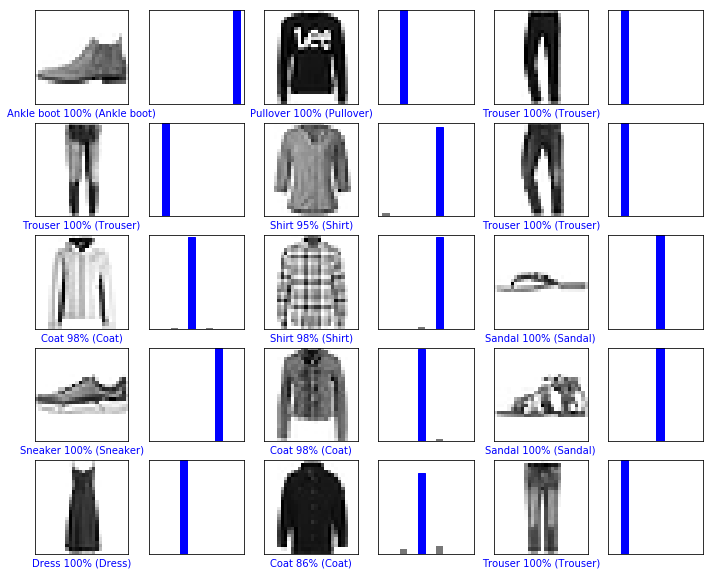

In [0]:
plot_correct_or_incorrect(range(100), 5, 3, True)

Incorrect labels:

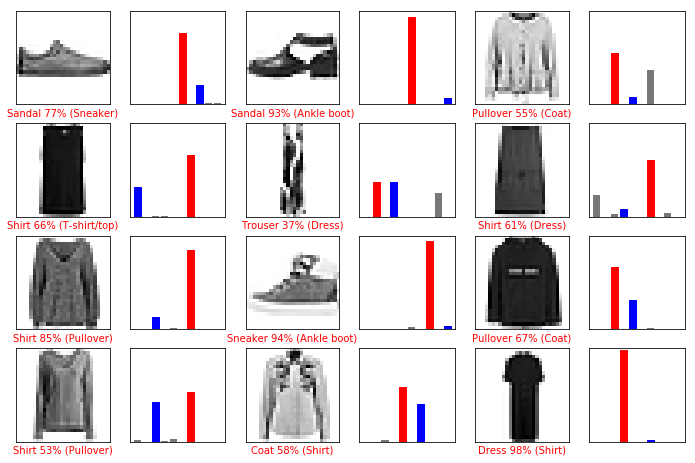

In [0]:
plot_correct_or_incorrect(range(150), 5, 3, False)

## Other designs

I would try the Cyclical Learning Rates method to alleviate the burden of finding the learning rates. It is known that the learning rate is the most important hyper-parameter to tune for training deep neural networks. This paper (https://arxiv.org/abs/1506.01186) describes a new method for setting the learning rate, named cyclical learning rates, which practically eliminates the need to experimentally find the best values and schedule for the global learning rates. Instead of monotonically decreasing the learning rate, this method lets the learning rate cyclically vary between reasonable boundary values.

I would propose to use a pre-trained model, that is, a model created by someone else to solve a different problem. Instead of building a model from scratch to solve a similar problem, I would l use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. Steps:
  1. Resizing the images to the desired resolution required for the input layer into the pre-trained CNN. Pre-trained weights are optimized for much larger images. Taking a 28 x 28 image and resizing to a 224 x 224 image would pose severe interpolation artifacts. We could try with interpolations like bilinear or bicubic.
  2. Because the MNIST digits are originally grayscale, we will need to replicate the single channel image into a multi-channel image so that it artificially becomes RGB. This means that the red, green and blue channels are all the same and is the MNIST grayscale counterpart.
  3. Replacing the last layer of the pre-trained model and train our softmax layer with our corresponding labels. We want to fix the weights in all the other layers since otherwise, we'll have one layer with random weights, which will cause the other layers to quickly move a long way from their optimized ImageNet weights.
  4. Now that we have a good final layer trained, we can try fine-tuning the other layers. Note that the other layers have already been trained to recognize ImageNet photos so we want to be careful of not destroying the carefully tuned weights that are already there. Generally speaking, the earlier layers have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. We use different learning rates for different layers, for example, the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before.
